In [1]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import random
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from timm.utils import *
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from cutmix.cutmix import CutMix
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
from timm.optim import create_optimizer
#from pytorch_metric_learning import loss
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from cutmix.utils import CutMixCrossEntropyLoss
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
from timm.scheduler import create_scheduler, CosineLRScheduler
from timm.models import resume_checkpoint, load_checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score
#from timm.data import Dataset, DatasetTar, RealLabelsImagenet, create_loader, Mixup, FastCollateMixup, AugMixDataset

In [2]:
data_dir = '/home/linh/Downloads/TB/'


# Define your transforms for the training and testing sets
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
batch_size = 128
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=8, pin_memory = True)
              for x in [ 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

class_names = image_datasets['test'].classes
num_classes = len(class_names)
print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()

['Normal', 'TB']
{'test': 165}
cuda:0
{0: 'Normal', 1: 'TB'}


torch.Size([128, 3, 224, 224])

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    plt.show()

In [10]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b3', pretrained=True, drop_rate=0.3)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = LabelSmoothingCrossEntropy()
#criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)

The number of parameters of the model is: 14863946


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs
checkpoint loaded
Inference time is 0m 12s
              precision    recall  f1-score   support

           0     0.9579    0.9381    0.9479        97
           1     0.9143    0.9412    0.9275        68

    accuracy                         0.9394       165
   macro avg     0.9361    0.9397    0.9377       165
weighted avg     0.9399    0.9394    0.9395       165



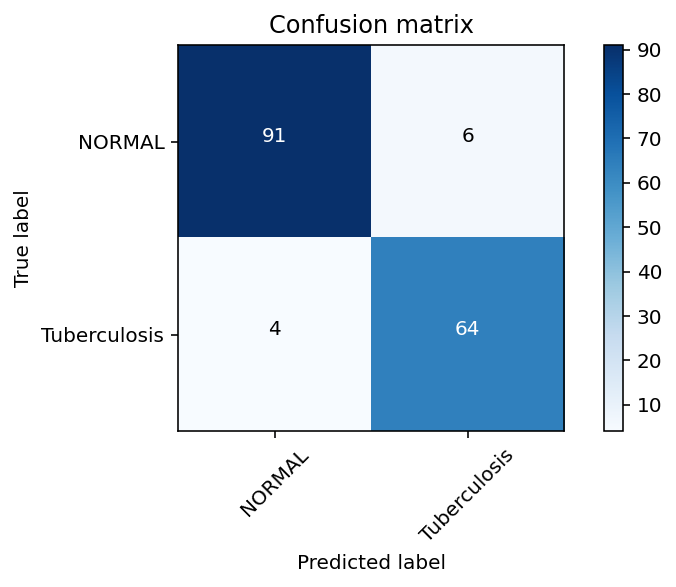

In [7]:
%time
CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B0.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        
time_elapsed = time.time() - since

print('Inference time is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['NORMAL', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs
checkpoint loaded
Training complete in 0m 10s
              precision    recall  f1-score   support

           0     0.9231    0.9897    0.9552        97
           1     0.9836    0.8824    0.9302        68

    accuracy                         0.9455       165
   macro avg     0.9533    0.9360    0.9427       165
weighted avg     0.9480    0.9455    0.9449       165



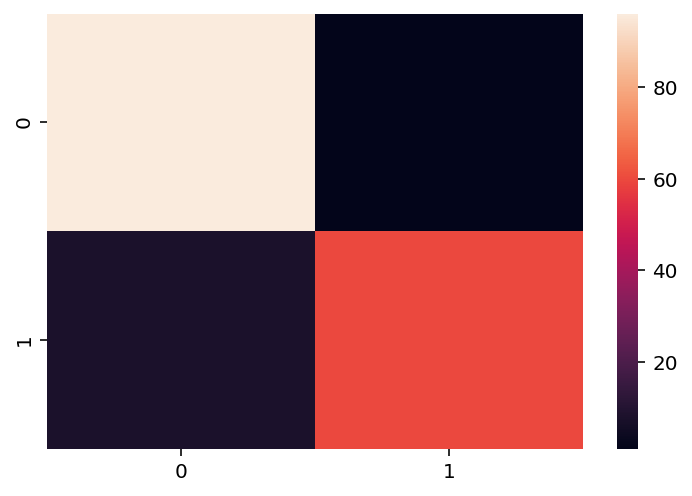

In [11]:
%time
CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B3.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()
y_test = []
y_pred = []
with torch.no_grad():
    for images, labels in data_loader['test']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model(images)
        _, predictions = outputs.max(1)
    
        y_test.append(labels.data.cpu().numpy())
        y_pred.append(predictions.data.cpu().numpy())


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B0.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B1.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B2.csv',index=False)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B3.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/Ensemble_Voting_EfficientNet_B0_B1_B2_B3.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

# Ensemble Voting of EfficientNet-B0 + EfficientNet-B1 + EfficientNet-B2 + EfficientNet-B3

In [4]:
def get_Eff_B0():
    model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.2)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B0.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model

def get_Eff_B1():
    model = timm.create_model('efficientnet_b1', pretrained=True, drop_rate=0.2)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B1.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model

def get_Eff_B2():
    model = timm.create_model('efficientnet_b2', pretrained=True, drop_rate=0.3)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B2.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model

def get_Eff_B3():
    model = timm.create_model('efficientnet_b3', pretrained=True, drop_rate=0.3)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B3.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model

In [7]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.Eff_B0 = get_Eff_B0()
        self.Eff_B1 = get_Eff_B1()
        self.Eff_B2 = get_Eff_B2()
        self.Eff_B3 = get_Eff_B3()
    def forward(self, x):
        x1 = self.Eff_B0(x)
        x2 = self.Eff_B1(x)
        x3 = self.Eff_B2(x)
        x4 = self.Eff_B3(x)


        x = sum([x1, x2, x3, x4]) / 4
        return x
    
model = Ensemble_Model()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs
Inference time is 0m 10s
              precision    recall  f1-score   support

           0     0.9505    0.9897    0.9697        97
           1     0.9844    0.9265    0.9545        68

    accuracy                         0.9636       165
   macro avg     0.9674    0.9581    0.9621       165
weighted avg     0.9645    0.9636    0.9635       165



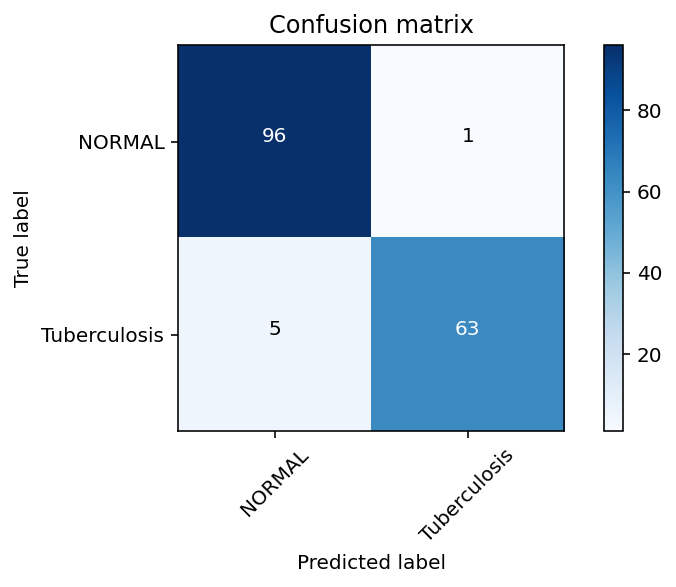

In [8]:
%time

model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        
time_elapsed = time.time() - since

print('Inference time is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['NORMAL', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

Training complete in 0m 10s
              precision    recall  f1-score   support

           0     0.9505    0.9897    0.9697        97
           1     0.9844    0.9265    0.9545        68

    accuracy                         0.9636       165
   macro avg     0.9674    0.9581    0.9621       165
weighted avg     0.9645    0.9636    0.9635       165



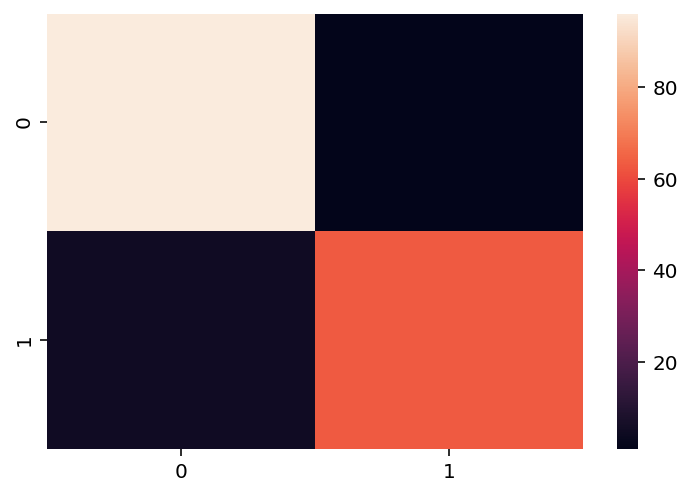

In [9]:
since = time.time()
model.eval()
y_test = []
y_pred = []
with torch.no_grad():

    for images, labels in data_loader['test']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model(images)
        _, predictions = outputs.max(1)
    
        y_test.append(labels.data.cpu().numpy())
        y_pred.append(predictions.data.cpu().numpy())


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B0.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B1.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B2.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/EfficientNet-B3.csv',index=False)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/TB/results/Ensemble_Voting_EfficientNet_B0_B1_B2_B3.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)